### 数据准备

In [3]:

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU,Attention
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [2]:
ravdess = "./audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
Crema = "./AudioWAV/"
Tess = "./TESS Toronto emotional speech set data/"


数据预处理

#### RAVDESS数据集

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

In [4]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [5]:
print(actor[0])
print(part[0])
print(file_path[0])


03-01-01-01-01-01-24.wav
03
./audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav


In [6]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# 根据序号确定情绪类型
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
# 查看数据
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0  neutral  ./audio_speech_actors_01-24/Actor_01/03-01-01-...
1  neutral  ./audio_speech_actors_01-24/Actor_01/03-01-01-...
2  neutral  ./audio_speech_actors_01-24/Actor_01/03-01-01-...
3  neutral  ./audio_speech_actors_01-24/Actor_01/03-01-01-...
4  neutral  ./audio_speech_actors_01-24/Actor_01/03-01-02-...
______________________________________________
      Emotions                                               Path
1435  surprise  ./audio_speech_actors_01-24/Actor_24/03-01-08-...
1436  surprise  ./audio_speech_actors_01-24/Actor_24/03-01-08-...
1437  surprise  ./audio_speech_actors_01-24/Actor_24/03-01-08-...
1438  surprise  ./audio_speech_actors_01-24/Actor_24/03-01-08-...
1439  surprise  ./audio_speech_actors_01-24/Actor_24/03-01-08-...
_______________________________________________
Emotions
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dty

#### CREMA-D数据集

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


#### TESS

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [8]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe cho emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe cho đường dẫn của file
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64


Join dataset

In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,./audio_speech_actors_01-24/Actor_01/03-01-01-...
1,neutral,./audio_speech_actors_01-24/Actor_01/03-01-01-...
2,neutral,./audio_speech_actors_01-24/Actor_01/03-01-01-...
3,neutral,./audio_speech_actors_01-24/Actor_01/03-01-01-...
4,neutral,./audio_speech_actors_01-24/Actor_01/03-01-02-...


In [10]:
print(data_path.Emotions.value_counts())

Emotions
happy       1863
sad         1863
angry       1863
fear        1863
disgust     1863
neutral     1775
surprise     592
Name: count, dtype: int64


数据分布的一点可视化 

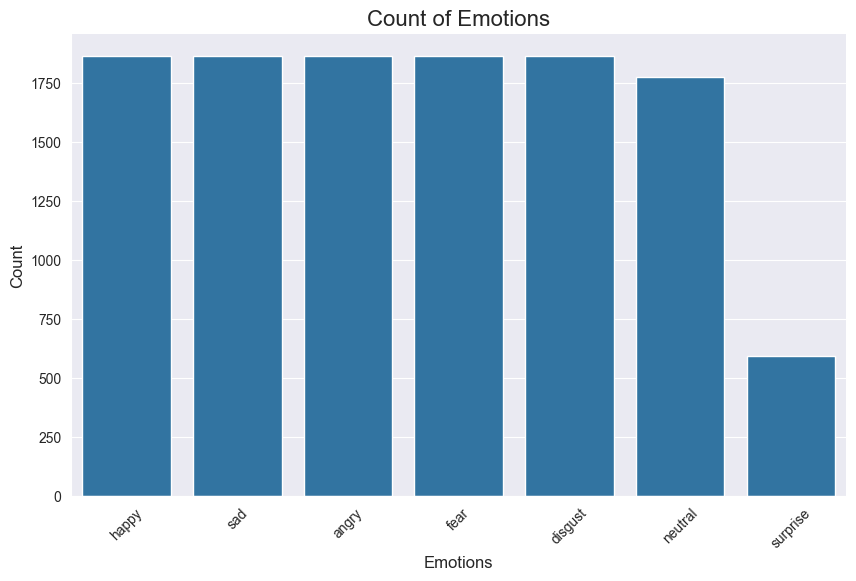

In [11]:
# 查看各类情绪的数量
import matplotlib.pyplot as plt
import seaborn as sns

emotion_counts = data_path['Emotions'].value_counts()
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45) 
sns.despine(top=True, right=True, left=False, bottom=False)


In [12]:
data_array, sample_rate = librosa.load(data_path['Path'].iloc[0])
sample_rate

22050

In [13]:
ipd.Audio(data_array,rate=sample_rate)

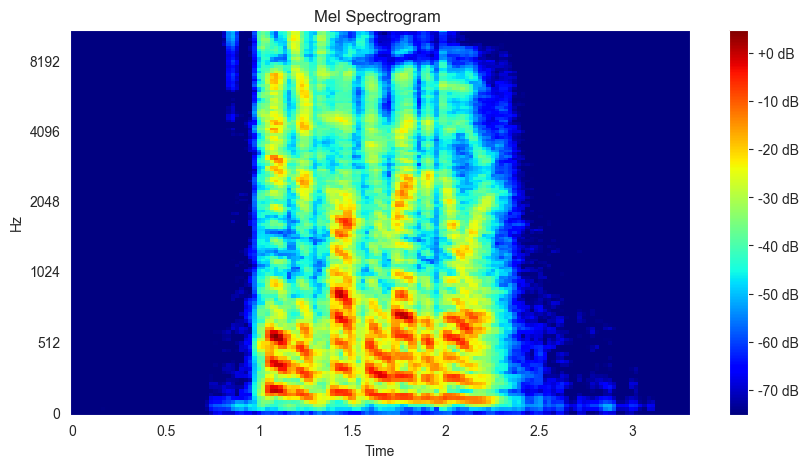

In [14]:
# 绘制Mel频谱图
plt.figure(figsize=(10, 5))
# 使用librosa计算音频信号的Mel频谱图
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000)
# 将Mel频谱图转换为分贝（Decibel）单位
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time',cmap=plt.cm.jet);
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')


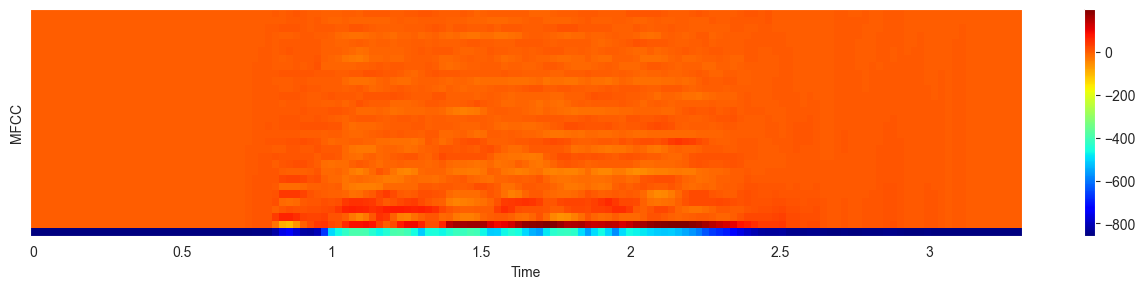

In [15]:
#计算Mel频率倒谱系数（MFCC）特征
mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc=30)
'''
返回的结果是一个矩阵，大小为 (n_mfcc, T)，其中 n_mfcc
是MFCC系数的数量，T 是音频信号中的时间帧数。
矩阵的每一行对应一个MFCC系数，每一列对应一个时间帧。
MFCC通常用于表征音频特征，广泛应用于语音处理和音乐领域。
'''
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time',cmap=plt.cm.jet)
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data_array,rate=sample_rate)

### 数据增强
noise 函数：通过向原始音频添加随机噪声，模拟真实世界中的噪声情况，使模型更能适应噪声环境。

stretch 函数：进行时间拉伸，调整音频的播放速率。这对于模拟不同的语速或语气变化非常有用。

shift 函数：进行时间平移，即将音频数据在时间轴上平移。这有助于模型学习对时间偏移的鲁棒性。

pitch 函数：进行音调变换，改变音频的音调。这对于模拟不同音高的说话人或音乐效果很有用。

In [16]:
# 生成随机噪声
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# 调整速度
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)
# 时间平移
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# 音调变换
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

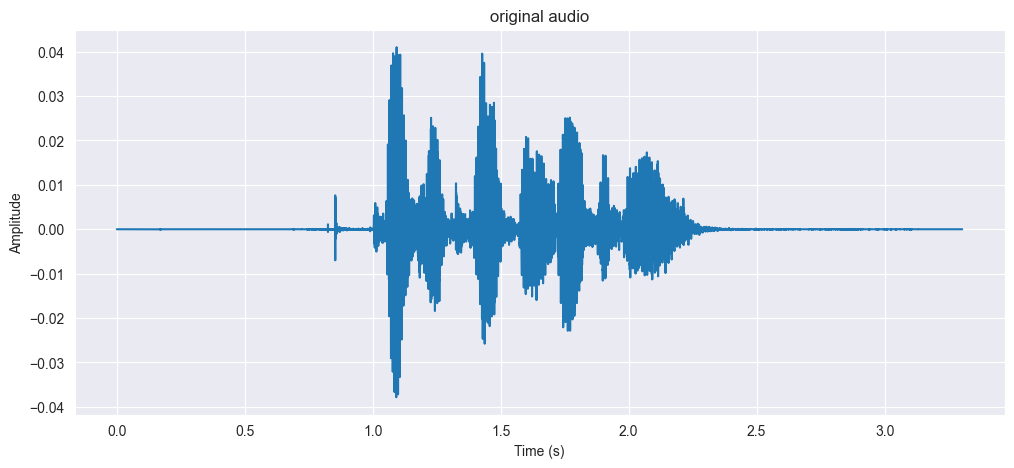

In [17]:
# 原音频
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(len(data_array)) / sample_rate, y=data_array)
plt.title('original audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(data_array,rate=sample_rate)


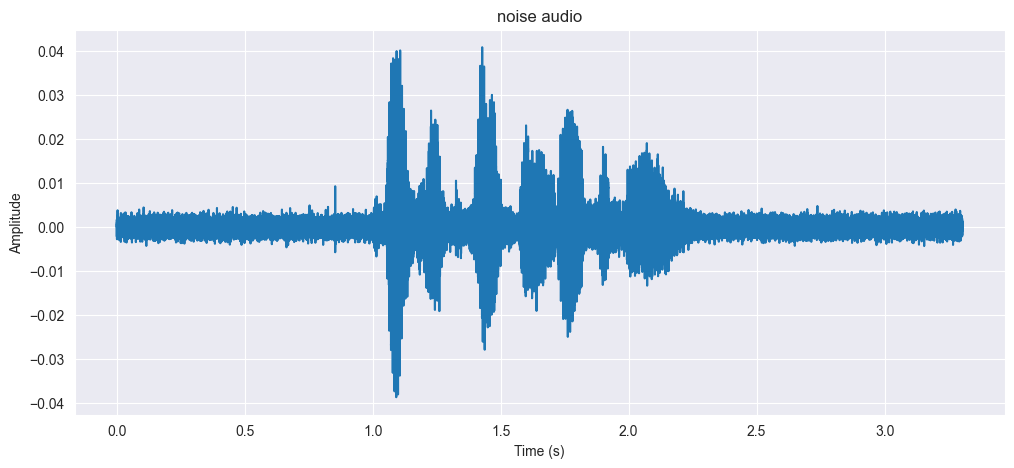

In [18]:
# 增加噪音
x = noise(data_array)
plt.figure(figsize=(12,5))
sns.lineplot(x=np.arange(len(x)) / sample_rate, y=x)
plt.title('noise audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(x,rate=sample_rate)

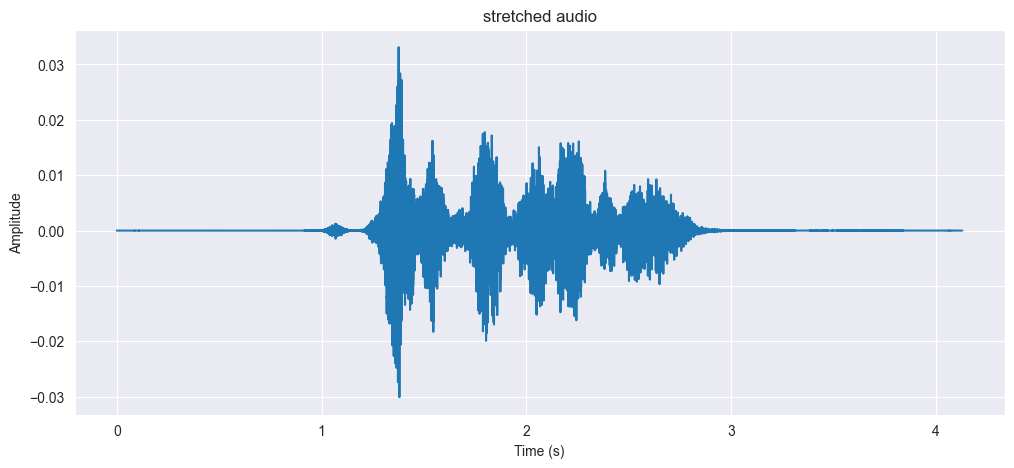

In [19]:
# 调整速度
x = stretch(data_array)
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(len(x)) / sample_rate, y=x)
plt.title('stretched audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(x,rate=sample_rate)

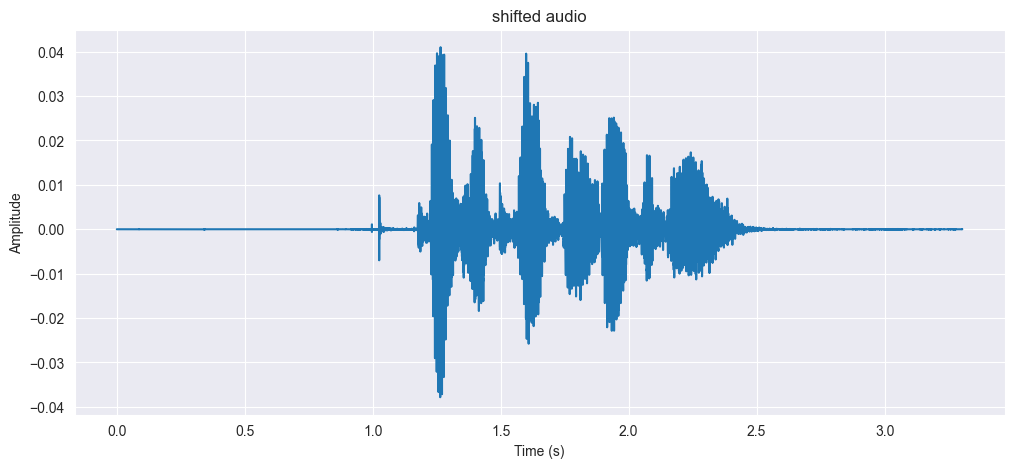

In [20]:
# 平移语音
x = shift(data_array)
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(len(x)) / sample_rate, y=x)
plt.title('shifted audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(x,rate=sample_rate)

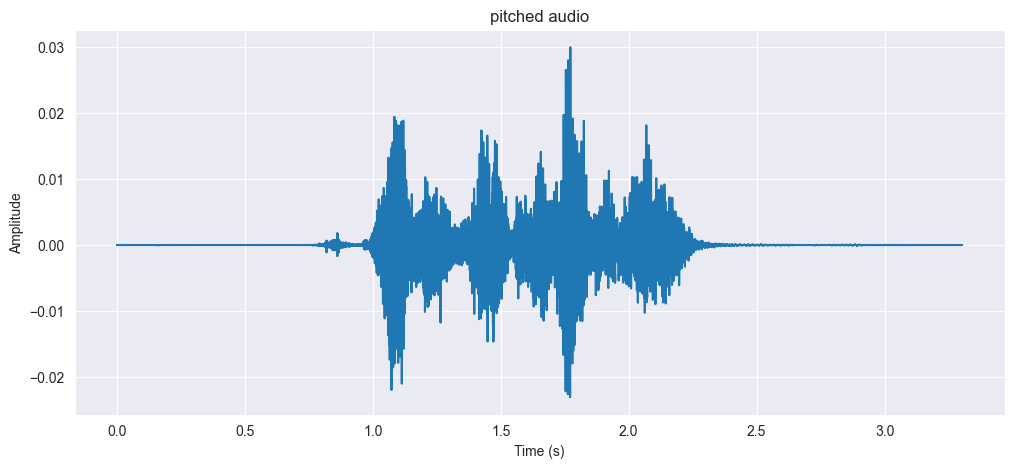

In [21]:
# 语音变调
x = pitch(data=data_array,sampling_rate=sample_rate)
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(len(x)) / sample_rate, y=x)
plt.title('pitched audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
ipd.Audio(x,rate=sample_rate)

### Feature Extraction

In [22]:
# 计算过零率（Zero Crossing Rate）- 返回一维数组
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# 计算均方根误差（Root Mean Square Error）
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# 计算梅尔频率倒谱系数（MFCC）
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

'''
提取特征。此函数结合了过零率（ZCR）、均方根误差（RMSE）和梅尔频率倒谱系数（MFCC）等特征，
以创建音频数据的完整特征向量。
'''
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path=path, duration=duration, offset=offset)
    aud = extract_features(data)  # 提取特征
    audio = np.array(aud)  # 将特征转换为数组

    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))

    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))

    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))

    return audio

### Get feature

In [23]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [24]:
from joblib import Parallel, delayed
import timeit

# 计时开始
start = timeit.default_timer()

# 定义处理单个音频文件的函数
def process_feature(path, emotion):
    # 提取特征
    features = get_features(path)
    X = []
    Y = []
    # 将特征和对应的情感标签存储到 X 和 Y 中
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

# 获取音频文件路径和相应的情感标签
paths = data_path.Path
emotions = data_path.Emotions

# 并行处理特征提取
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# 整理结果
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

# 计时结束
stop = timeit.default_timer()

# 打印处理时间
print('Time: ', stop - start)   

Time:  163.20743359999324


In [25]:
len(X), len(Y), data_path.Path.shape

(46728, 46728, (11682,))

### Saving features

In [26]:
emotions = pd.DataFrame(X)
emotions['Emotions'] = Y
emotions.to_csv('emotion.csv', index=False)
emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.255371,0.387207,0.520020,0.517578,0.510742,0.497559,0.496094,0.493652,0.499023,0.504395,...,2.401795,-0.474629,-2.913549,-3.015972,0.232527,-3.969743,-8.424656,-8.193398,-5.259051,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006713,0.006601,0.006483,0.006356,0.006218,0.006066,0.005919,0.005759,0.005588,neutral
3,0.253906,0.381348,0.509766,0.517090,0.507812,0.495605,0.488770,0.480957,0.491699,0.511230,...,0.113279,3.847988,4.949723,4.131155,-7.171700,-9.205718,-1.212739,1.373744,5.612038,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [4]:
Emotions = pd.read_csv('emotion.csv')

In [28]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [5]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [30]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

### 数据准备

In [6]:
Y=Emotions['Emotions']
X= Emotions.drop('Emotions',axis= 1)

In [32]:
X.shape

(46728, 2376)

In [33]:
Y.shape

(46728,)

In [7]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
Y.shape

(46728, 7)

In [36]:
Y[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [8]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=35,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [9]:
#reshape for lstm
X_train = x_train.to_numpy().reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.to_numpy().reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [39]:
X_train.shape

(37382, 2376, 1)

In [10]:
# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [41]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.00001)

### SVM

In [42]:
Y_svm=Emotions['Emotions']
X_svm= Emotions.drop('Emotions',axis= 1)

In [43]:
#train test split
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, Y_svm, random_state=35,test_size=0.2, shuffle=True)
x_train_svm.shape, y_train_svm.shape, x_test_svm.shape, y_test_svm.shape

((37382, 2376), (37382,), (9346, 2376), (9346,))

In [ ]:
from sklearn import svm
model_svm = svm.SVC(kernel='linear')

# 训练模型
model_svm.fit(x_train_svm, y_train_svm)

### KNN


### LSTM model

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM as LSTM
# Define the input shape
input_seq = Input(shape=(x_train.shape[1], 1))

lstm1 = LSTM(512, return_sequences=True)(input_seq)
dropout1 = Dropout(0.3)(lstm1)
dense1 = Dense(256, activation='relu')(dropout1)
lstm2 = LSTM(256, return_sequences=True)(dense1)
dropout2 = Dropout(0.2)(lstm2)
dense2 = Dense(128, activation='relu')(dropout2)
lstm3 = LSTM(128, return_sequences=True)(dense2)
dropout3 = Dropout(0.3)(lstm3)


def attention_layer(inputs):
    return tf.keras.layers.Attention()([inputs, inputs])

attention_output = Lambda(attention_layer)(lstm3)

lstm_final = LSTM(128)(attention_output)

output = Dense(7, activation='softmax')(lstm_final)

model_with_attention = Model(inputs=input_seq, outputs=output)

model_with_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_with_attention.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2376, 1)]         0         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 2376, 512)         1054720   
                                                                 
 dropout (Dropout)           (None, 2376, 512)         0         
                                                                 
 dense (Dense)               (None, 2376, 256)         131328    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 2376, 256)         526336    
                                                                 
 dropout_1 (Dropout)         (None, 2376, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 2376, 128)         32896 

In [ ]:
tf.keras.utils.plot_model(model_with_attention, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist=model_with_attention.fit(X_train, y_train,
            epochs=50,
            validation_data=(X_test, y_test),batch_size=32,
            verbose=1)

Epoch 1/50


In [ ]:
print("Accuracy of our model on test data : " , model_with_attention.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model_with_attention.predict(x_test)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

### CNN model

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2), 
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

### CLSTM

In [ ]:
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dense(512, activation='relu'))
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dense(256, activation='relu'))
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()

In [ ]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist1=model000.fit(x_traincnn, y_train, batch_size=128, epochs=50, validation_data=(x_testcnn, y_test))

In [ ]:
print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model000.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)